In [72]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ncxt_psftomo

from ncxt_psftomo.reconstruct import CG_BL, CG_PSF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PSF correction in soft X-ray tomography
Ekman, Axel, et al. "PSF correction in soft X-ray tomography." _Journal of structural biology_ 204.1 (2018): 9-18. https://www.sciencedirect.com/science/article/pii/S1047847718301412

In [73]:
# Projections are faster in float32
dtype = 'float32'

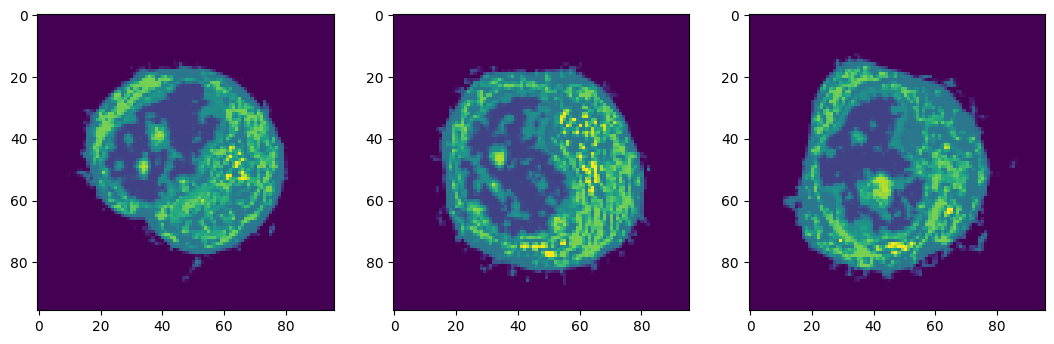

In [74]:
phantom = ncxt_psftomo.read_write_mrc.read_mrc('data/phantom.mrc').astype(dtype)
pad = 16
phantom= phantom[pad:-pad,pad:-pad,pad:-pad]
ncxt_psftomo.plotters.volshow(phantom)
plt.show()

### Example PSF
- As an example, we here use a theoretical incoherent PSF (Born, Max, and Emil Wolf. _Principles of optics: electromagnetic theory of propagation, interference and diffraction of light._) 

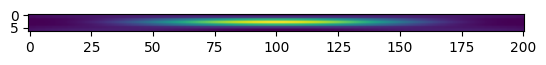

In [75]:
resolution = 3
dof = 50
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,resolution,101)
plt.imshow(ncxt_psftomo.psf_utils.psf_slice(resolution,dof,resolution,201))
plt.show()

### Dimenstions
- The data format is 
    - volume: (horizontal x,horizontal y,vertical)
    - projections: (angles, horizontal, vertical)
    - PSF: (axial, horizontal, vertical)

In [77]:
angles = np.linspace(0,np.pi,90,endpoint = False)
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = dtype)
projections_bl = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype = dtype)

ncxt_psftomo.forward_bl(1.0*phantom, projections_bl, angles)
ncxt_psftomo.forward(1.0*phantom, projections,psf, angles)

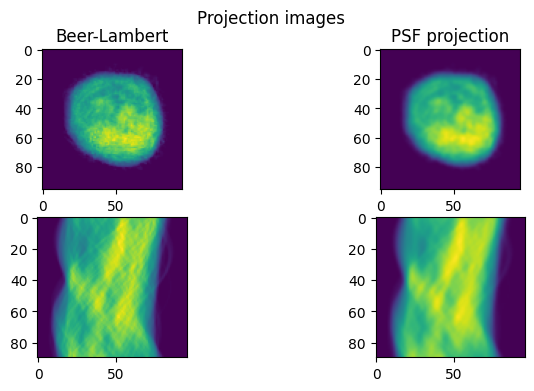

In [78]:
vertical_index = phantom.shape[0]//2
f,axes = plt.subplots(ncols=2,nrows = 2,figsize=(8,4))
axes[0,0].imshow(projections_bl[0].transpose())
axes[0,1].imshow(projections[0].transpose())

axes[1,0].imshow(projections_bl[:,:,vertical_index])
axes[1,1].imshow(projections[:,:,vertical_index])

plt.suptitle("Projection images")
axes[0,0].set_title("Beer-Lambert")
axes[0,1].set_title("PSF projection")
plt.show()

### Example reconstruction using CGLS

### Ideal projections

  0%|          | 0/10 [00:00<?, ?it/s]

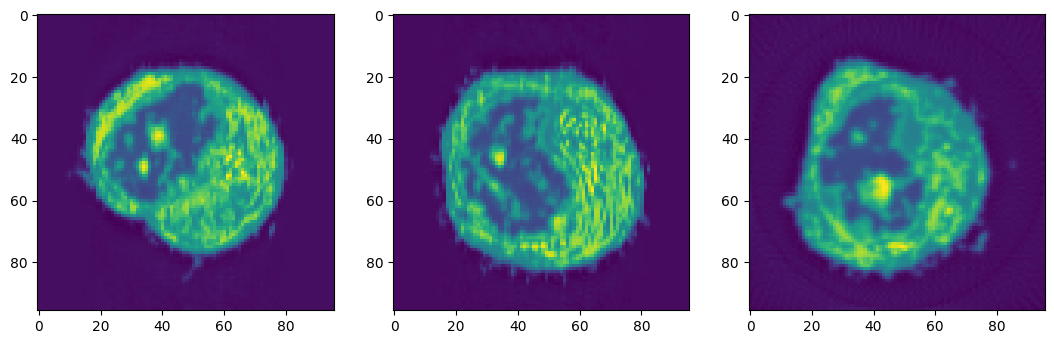

In [83]:
rec_test = np.zeros(phantom.shape, dtype = dtype)
rec_test = CG_BL(rec_test, projections_bl, angles, 10, chatty=False, disable_tqdm=False)
ncxt_psftomo.plotters.volshow(rec_test)
plt.show()

### PSF limited projections

  0%|          | 0/30 [00:00<?, ?it/s]

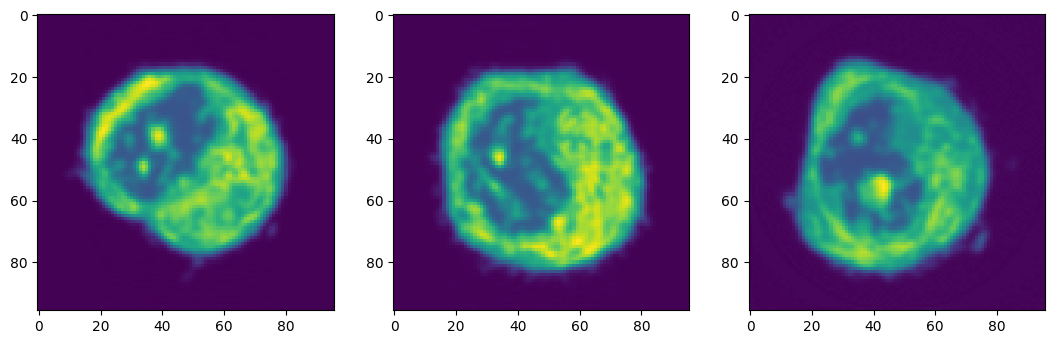

In [84]:
rec_bl = np.zeros(phantom.shape, dtype = dtype)
rec_bl = CG_BL(rec_bl, projections, angles, 30, chatty=False, disable_tqdm=False)
ncxt_psftomo.plotters.volshow(rec_bl)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

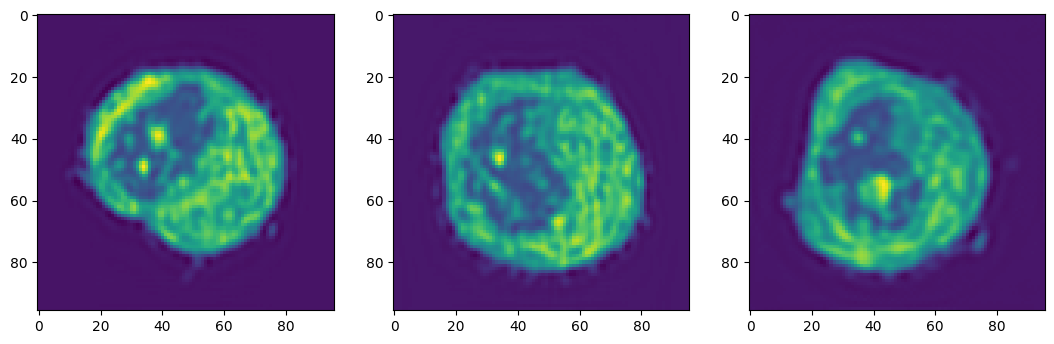

In [85]:
rec_psf = np.zeros(phantom.shape, dtype = dtype)
rec_psf = CG_PSF(rec_psf, projections,psf, angles, 30, chatty=False, disable_tqdm=False)
ncxt_psftomo.plotters.volshow(rec_psf)
plt.show()

<Figure size 640x480 with 0 Axes>

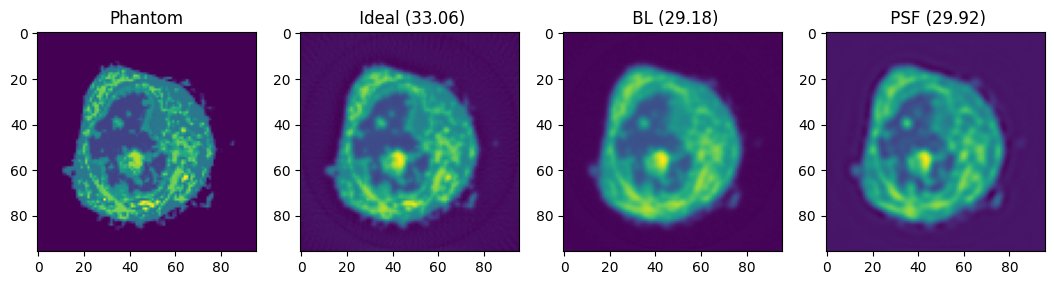

In [88]:
from skimage.metrics import peak_signal_noise_ratio
f, axes = plt.subplots(ncols = 4, figsize = (13,5))
axes[0].imshow(phantom[:,:,R])
axes[1].imshow(rec_test[:,:,R])
axes[2].imshow(rec_bl[:,:,R])
axes[3].imshow(rec_psf[:,:,R])

axes[0].set_title('Phantom')
axes[1].set_title(f' Ideal ({peak_signal_noise_ratio(rec_test,phantom, data_range=np.max(phantom)):.2f})')
axes[2].set_title(f' BL ({peak_signal_noise_ratio(rec_bl,phantom, data_range=np.max(phantom)):.2f})')
axes[3].set_title(f' PSF ({peak_signal_noise_ratio(rec_psf,phantom, data_range=np.max(phantom)):.2f})')
plt.savefig('example_PSNR', bbox_inches = 'tight')
plt.show()
